# 0. Generic imports / setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyemma
%matplotlib inline

# 1. Example data

In [82]:
#from msmbuilder.example_datasets import AlanineDipeptide
#ala = AlanineDipeptide().get()
#trajs = ala.trajectories

from msmbuilder.example_datasets import MetEnkephalin
met = MetEnkephalin().get()
trajs = met.trajectories

# 2. Parameterize MSM

In [84]:
from msmbuilder.featurizer import AtomPairsFeaturizer

pairs = []
for i in range(trajs[0].n_atoms):
    for j in range(i):
        pairs.append((i,j))
apf = AtomPairsFeaturizer(pairs)

X = apf.fit_transform(trajs)
tica = pyemma.coordinates.tica(X,lag=50)
X_tica = [x[:,:50] for x in tica.get_output()]

kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica,k=200,max_iter=1000)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

08-07-16 14:14:24 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4] INFO     Cluster centers converged after 476 steps.


In [85]:
lags = range(1,100)
its = pyemma.msm.its(dtrajs,lags,nits=10)

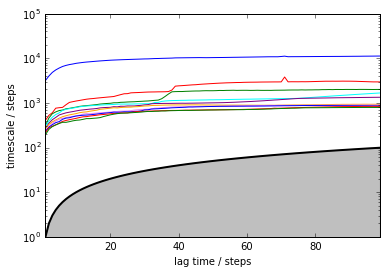

In [86]:
pyemma.plots.plot_implied_timescales(its)

In [87]:
msm = pyemma.msm.estimate_markov_model(dtrajs,20)

## 2.1. Compute properties of interest

### 2.1.1. Microstate MFPT matrix

In [88]:
n = msm.nstates
mfpt = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        mfpt[i,j] = msm.mfpt(i,j)

### 2.1.2. Timescales

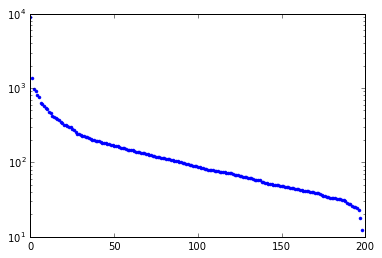

In [89]:
plt.plot(msm.timescales(),'.')
plt.yscale('log')

# 3. Identify metastable states

In [117]:
n_metastable = 4
pcca = msm.pcca(n_metastable)
[len(s) for s in pcca.metastable_sets]
# huh, this is super unbalanced

[4, 5, 157, 34]

In [118]:
hmm = msm.coarse_grain(n_metastable)
hmm.stationary_distribution,[len(s) for s in hmm.metastable_sets]

08-07-16 14:44:22 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Requested coarse-grained model with 4 metastable states at lag=20.The ratio of relaxation timescales between 4 and 5 states is only 1.07084860634 while we recommend at least 1.5.  It is possible that the resulting HMM is inaccurate. Handle with caution.


(array([ 0.17721271,  0.31394708,  0.18116544,  0.32767477]), [34, 89, 43, 34])

In [119]:
metastable_sets = hmm.metastable_sets

## 3.1. Identify the cores of each state

In [120]:
selection_criterion = lambda mfpt_out:max(mfpt_out)
core_states = np.zeros(n_metastable,dtype=int)

for i in range(n_metastable):
    s = metastable_sets[i]
    mfpt_ = mfpt[s][:,s]
    ind = np.argmin([selection_criterion(m) for m in mfpt_])
    core_states[i] = s[ind]

In [121]:
core_states

array([180,  59, 167,  65])

## 3.2. Look at brute-force escape times for each state

In [122]:
brute_force_mfpt_out = np.zeros(len(core_states))
for i in range(len(core_states)):
    i_complement = list(set(msm.active_set) - set(metastable_sets[i]))
    brute_force_mfpt_out[i] = msm.mfpt(core_states[i],i_complement)
print(brute_force_mfpt_out)

[  1890.40893043   1486.18175438    925.60771105  13022.8411984 ]


## 3.4. Other random things

### 3.4.1. MFPTs between metastable sets

In [123]:
msm.mfpt(core_states[0],core_states[1])

162645.38857776774

In [124]:
meta_mfpt = np.zeros((n_metastable,n_metastable))
for i in range(n_metastable):
    for j in range(n_metastable):
        meta_mfpt[i,j] = msm.mfpt(pcca.metastable_sets[i],pcca.metastable_sets[j])

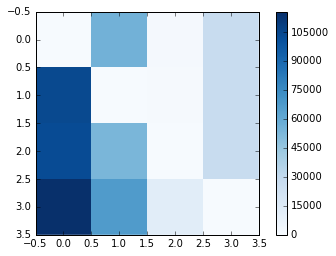

In [125]:
plt.imshow(meta_mfpt,interpolation='none',cmap='Blues')
plt.colorbar()

In [126]:
np.min(meta_mfpt[meta_mfpt!=0])

712.90958393897074

### 3.4.2. Committors

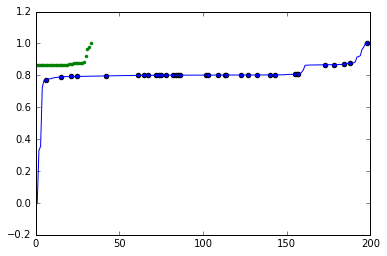

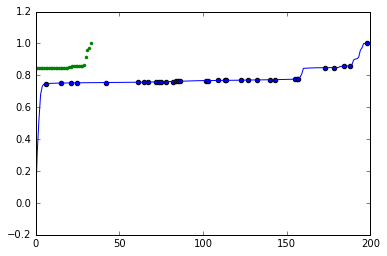

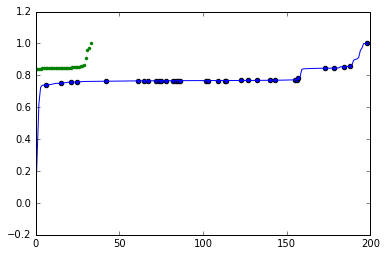

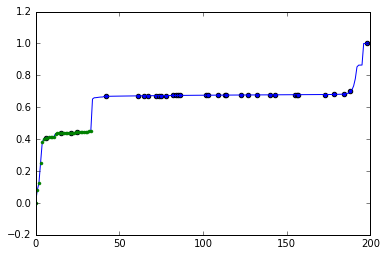

In [127]:
for c in core_states:
    plt.figure()
    committor = msm.committor_forward(c,list(set(core_states) - set([c])))
    plt.plot(sorted(committor))
    plt.plot(sorted(committor[pcca.metastable_sets[i]]),'.')
    plt.scatter(pcca.metastable_sets[i],np.array(sorted(committor))[pcca.metastable_sets[i]])
    plt.xlim(0,msm.nstates)

In [287]:
pcca.memberships.shape

(200, 4)

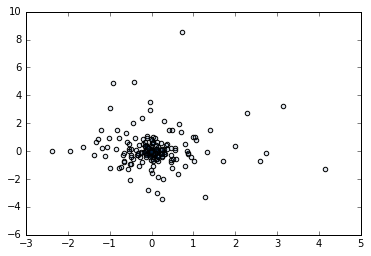

In [292]:
plt.scatter(msm.eigenvectors_right()[1],msm.eigenvectors_right()[2],c=pcca.memberships[0])

In [ ]:
# plot on eig vector 2 and 3

## 3.3. Write down orderings within each state

### Define orderings on microstates within each macrostate

### Committor-based ordering

In [128]:
orderings = []
for i,c in enumerate(core_states):
    committor = msm.committor_forward(c,list(set(core_states) - set([c])))
    all_sorted = np.argsort(committor)
    ordering = []
    for t in range(len(all_sorted)):
        if all_sorted[t] in pcca.metastable_sets[i]:
            ordering.append(all_sorted[t])
    orderings.append(ordering)

### Membership-based ordering

### Greedy ordering --> volume sequence

In [129]:
volume_sequences = []
for ordering in orderings:
    volume_sequence = [np.array(ordering[:i]) for i in range(1,len(ordering))]
    volume_sequences.append(volume_sequence)

### Estimate TIS efficiency

In [130]:
def direct_mfpts_out(msm,volume_sequence):
    core = volume_sequence[0]
    active_set = set(msm.active_set)
    return np.array([msm.mfpt(core,list(active_set-set(s))) for s in volume_sequence[1:]])

def interface_mfpt(msm,volume_A,volume_B):
    '''
    We want the MFPT for crossing from the interface surrounding volume_A to the interface surrounding volume_B.
    
    `MFPT(A,complement(B))` is the average time to cross interface B, given that I started randomly in volume_A.
    
    `MFPT(A,complement(A))` is the average time to cross interface A, given that I started randomly in volume_A.
    
    I think the quantity I want is `MFPT(A,complement(B)) - MFPT(A,complement(A))`.
    
    (Assuming volume_A is contained in volume_B)
    '''
    assert(set(volume_A).issubset(set(volume_B)))
    A = volume_A
    A_ = list(set(msm.active_set)-set(A))
    B = list(set(msm.active_set)-set(volume_B))
    return msm.mfpt(A,B) - msm.mfpt(A,A_)

def sequential_mfpts_out(msm,volume_sequence):
    active_set = set(msm.active_set)
    s = volume_sequence
    
    return np.array([interface_mfpt(msm,s[i],s[i+1]) for i in range(len(s)-1)])

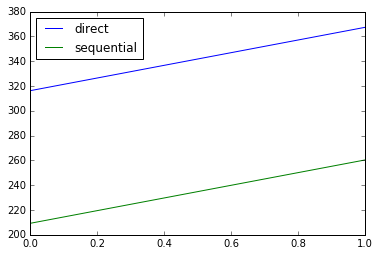

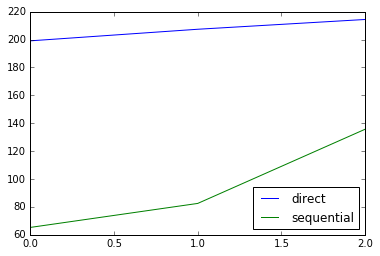

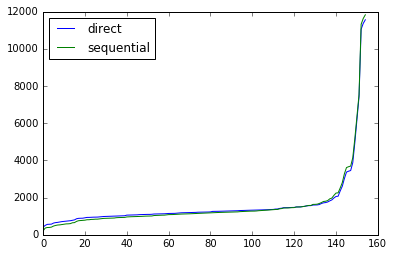

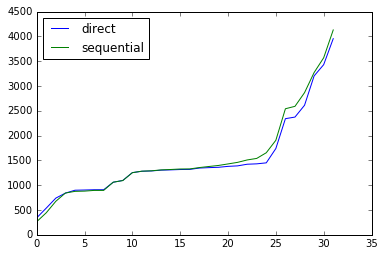

In [131]:
for volume_sequence in volume_sequences:
    dir_mfpts_out = direct_mfpts_out(msm,volume_sequence)
    seq_mfpts_out = sequential_mfpts_out(msm,volume_sequence)
    
    plt.figure()
    plt.plot(dir_mfpts_out,label='direct')
    plt.plot(np.cumsum(seq_mfpts_out),label='sequential')
    plt.legend(loc='best')

Max single-interface efficiency gain: 29.117%
Max single-interface efficiency gain: 54.742%
Max single-interface efficiency gain: 2.467%
Max single-interface efficiency gain: 3.751%


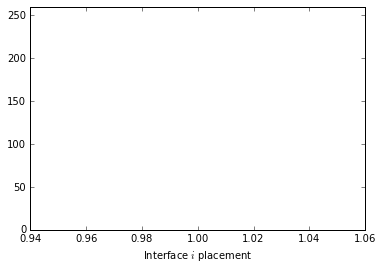

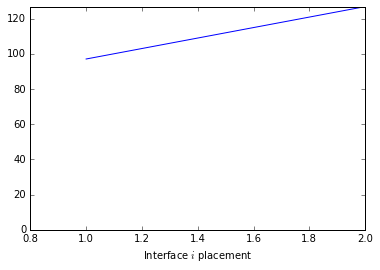

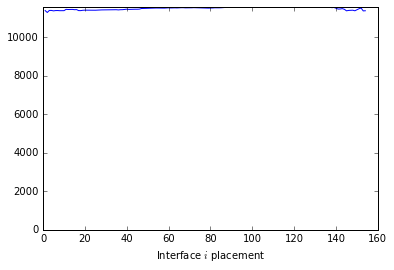

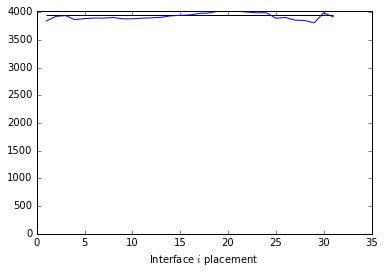

In [132]:
def plot_single_interface_efficiency(msm,volume_sequence):

    inds = range(1,len(volume_sequence)-1)
    costs = []

    for i in inds:
        seq = [volume_sequence[0],volume_sequence[i],volume_sequence[-1]]
        seq_mfpts = sequential_mfpts_out(msm,seq)
        costs.append(sum(seq_mfpts))

    mfpts_out = direct_mfpts_out(msm,volume_sequence)


    plt.plot(inds,costs)
    plt.ylim(0,max(costs))
    plt.hlines(mfpts_out[-1],min(inds),max(inds))
    plt.xlabel(r'Interface $i$ placement')
    
    print('Max single-interface efficiency gain: {0:.3f}%'.format(100*(mfpts_out[-1]-min(costs))/mfpts_out[-1]))
    

for volume_sequence in volume_sequences:
    plt.figure()
    plot_single_interface_efficiency(msm,volume_sequence)

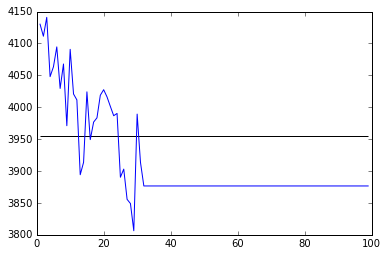

In [133]:
def plot_efficiency(msm,volume_sequence,strides):
    
    times_to_leave = []

    for stride in strides:
        seq = volume_sequence[::stride]
        if len(seq[-1]) != len(volume_sequence[-1]):
            seq.append(volume_sequence[-1])
        seq_mfpts = sequential_mfpts_out(msm,seq)
        times_to_leave.append(np.sum(seq_mfpts))

    plt.plot(strides,times_to_leave)
    mfpts_out = direct_mfpts_out(msm,volume_sequence)
    plt.hlines(mfpts_out[-1],min(strides),max(strides))

strides = range(1,100)
plot_efficiency(msm,volume_sequence,strides)

In [140]:
np.log(msm.committor_forward(core_states[1],list(set(metastable_sets[1])-set([core_states[1]]))))

array([  5.77315973e-15,   4.21884749e-15,   0.00000000e+00,
         4.44089210e-15,   0.00000000e+00,   0.00000000e+00,
         2.81996648e-14,   0.00000000e+00,   0.00000000e+00,
         1.77635684e-15,   0.00000000e+00,   4.44089210e-15,
         1.99840144e-15,   0.00000000e+00,   0.00000000e+00,
         2.70894418e-14,   4.66293670e-15,   3.55271368e-15,
         3.77475828e-15,   3.55271368e-15,   0.00000000e+00,
         2.77555756e-14,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.70894418e-14,   0.00000000e+00,
         2.66453526e-15,   4.66293670e-15,   0.00000000e+00,
         5.10702591e-15,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.22044605e-15,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.10702591e-15,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.75335310e-14,   0.00000000e+00,   1.77635684e-15,
         0.00000000e+00,   4.21884749e-15,   0.00000000e+00,
         0.00000000e+00,

# Misc

## Hitting time distributions

In [311]:
# 2D toy system where we can get a reference transition matrix
# and a reference committor
#def U(x):
#    well_locations =np.array( [
#                     [0,3],
#                     [3,0],
#                     ])
#    well_widths = np.ones(len(well_locations))*0.5
#    
#    u = 0
#    for i,well in enumerate(well_locations):
#        u += np.dot(x-well,x-well)/well_widths[i]
#    
#    return u# + np.sum(np.abs(x))

def U(x):
#    return np.sum(np.array(x)**4) + np.sum(np.array(x)**2)
    return np.sum(np.sin(x*10)) + np.sum(x**2)

def metropolis_criterion(U_i,U_j,beta=1.0):
    return min(1,np.exp(-beta*(U_j-U_i)))
    
def metropolis_T(x_i,x_j,neighbors_i,U,beta=1.0):
    U_i = U(x_i)
    num = metropolis_criterion(U_i,U(x_j))
    denom = np.sum([metropolis_criterion(U_i,U(x_k),beta=beta) for x_k in neighbors_i])
    return num / denom

In [258]:
U(np.array([3,0])),U(np.ones(2))

(8.0119683759071378, 0.91195777822126023)

In [315]:
metropolis_criterion(1,2)

0.36787944117144233

(-1.5, 1.5)

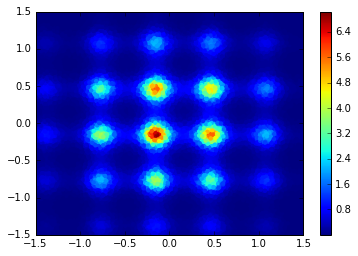

In [259]:
X = np.random.rand(100000,2)*3-1.5
y = np.array([U(x) for x in X])
plt.scatter(X[:,0],X[:,1],c=np.exp(-y),linewidths=0)
plt.colorbar()
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

In [260]:
ngrid = 50
x = np.linspace(-1.5,1.5,ngrid)
y = x

m = ngrid**2

T = np.zeros((m,m))

print(m)
print(m**2)

2500
6250000


In [261]:
coords = np.zeros((ngrid,ngrid,2))
for i in range(ngrid):
    for j in range(ngrid):
        coords[i,j] = [x[i],y[j]]

In [262]:
grid = np.zeros((ngrid,ngrid))
for i in range(ngrid):
    for j in range(ngrid):
        grid[i,j] = U(coords[i,j])

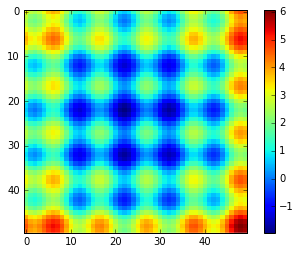

In [263]:
plt.imshow(grid,interpolation='none')
plt.colorbar()

In [264]:
# convert from i,j to flat

In [295]:
index_map = np.reshape(np.arange(m),(ngrid,ngrid))
T = np.zeros((m,m))

# can only take steps toward horizontal or vertical direct neighbors
neighbor_steps = np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1]])

for i in range(ngrid):
    for j in range(ngrid):
        neighbors = []
        for i_p,j_p in neighbor_steps:
            i_,j_ = i+i_p,j+j_p
            if min(i_,j_) >= 0 and max(i_,j_) < ngrid:
                neighbors.append((i_,j_))
        
        neighbor_coords = [coords[i_,j_] for (i_,j_) in neighbors]
        for (i_,j_) in neighbors:
            U_i = U(coords[i,j])
            #print(i,j,i_,j_,coords[i,j],coords[i_,j_],neighbors,U_i)
            #print(metropolis_criterion(U_i,U_i))
            T[index_map[i,j],index_map[i_,j_]] = metropolis_T(coords[i,j],coords[i_,j_],neighbor_coords,U)

(-1, 2501)

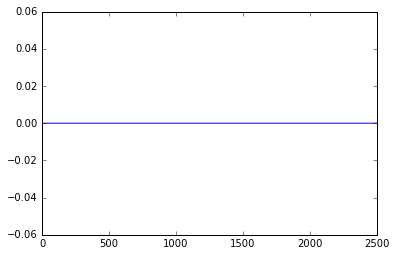

In [308]:
plt.plot(T[0])
plt.xlim(-1,2501)

In [310]:
sum(T[1])

1.0000000000000002

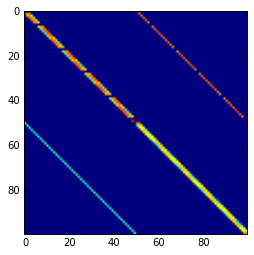

In [296]:
plt.imshow(T[:100][:,:100])

In [299]:
sum(T.sum(1)==0)

36

In [300]:
sum(T.sum(0)==0)

0

In [301]:
T.shape

(2500, 2500)

In [303]:
index_map==0

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [279]:
m = pyemma.msm.markov_model(T)

ValueError: T is not a transition matrix.

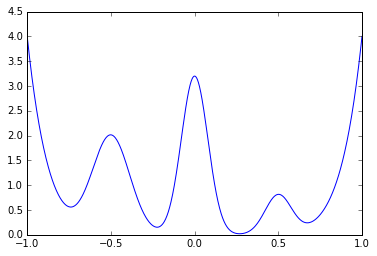

In [3]:
def quad_well(x):
    return 4*(x**8 + 0.8 * np.exp(-80 * x**2) + 0.2 * np.exp(-80 * (x-0.5)**2) + 0.5 * np.exp(-40 * (x+0.5)**2))

x = np.linspace(-1,1,1000)
plt.plot(x,quad_well(x))

In [4]:
def gaussian_metropolis_T(x_i,x_j,U,sigma2=0.001):
    U_i = U(x_i)
    U_j = U(x_j)
    return metropolis_criterion(U_i,U_j) * np.exp(-(x_i-x_j)**2 / sigma2)

In [5]:
grid = np.zeros((len(x),len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        grid[i,j] = gaussian_metropolis_T(x[i],x[j],quad_well)

NameError: global name 'metropolis_criterion' is not defined

In [6]:
grid.max()

0.0

In [462]:
T = (grid.T / grid.sum(1)).T

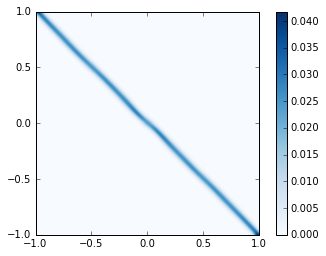

In [463]:
plt.imshow(np.linalg.matrix_power(T,2),cmap='Blues',extent=(x.min(),x.max(),x.min(),x.max()))
plt.colorbar()

In [464]:
vals, vecs = np.linalg.eig(T)

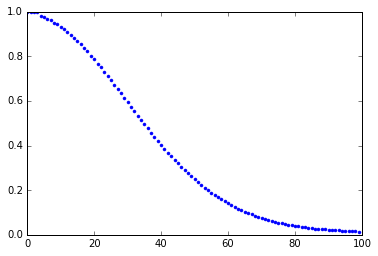

In [465]:
plt.plot(vals[:100],'.')

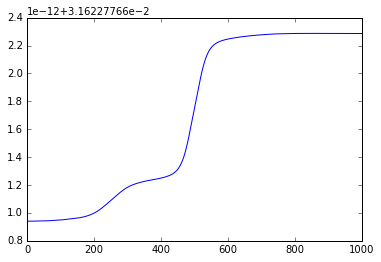

In [466]:
plt.plot(vecs[:,0])

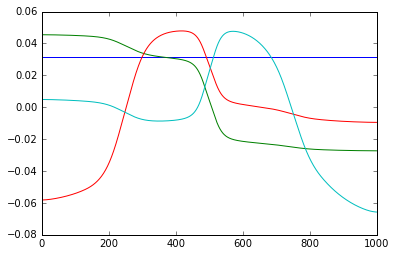

In [467]:
for i in range(4):
    plt.plot(vecs[:,i])

In [468]:
msm = pyemma.msm.markov_model(T)

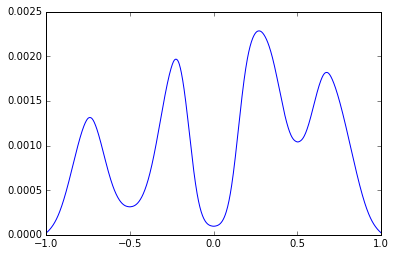

In [469]:
plt.plot(x,msm.eigenvectors_left()[0])

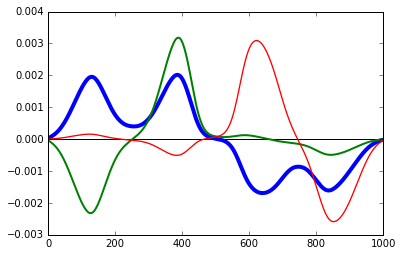

In [470]:
for i in range(1,4):
    plt.plot(msm.eigenvectors_left()[i],linewidth=4.0/i)
plt.hlines(0,0,1000)

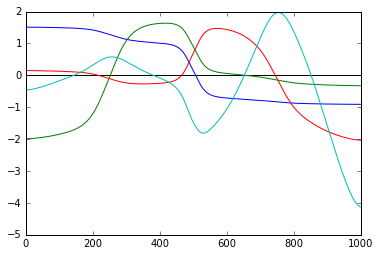

In [471]:
for i in range(1,5):
    plt.plot(msm.eigenvectors_left()[i]/msm.eigenvectors_left()[0])
plt.hlines(0,0,1000)

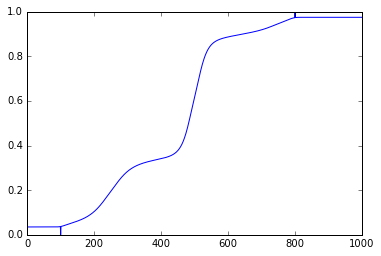

In [472]:
plt.plot(msm.committor_forward(100,800))

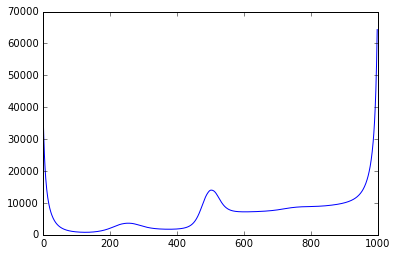

In [474]:
mfpt = [msm.mfpt(0,i) for i in range(1,1000)]
plt.plot(mfpt)

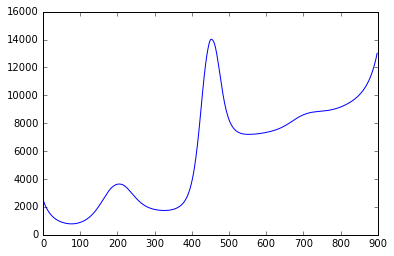

In [475]:
plt.plot(mfpt[50:-50])

In [1]:
np.logspace(1,3,100)

NameError: name 'np' is not defined

In [ ]:
for i in range(1,1000)[::10]:
    plt.figure()
    plt.imshow(np.linalg.matrix_power(msm.P,i),cmap='Blues',extent=(x.min(),x.max(),x.min(),x.max()))
    plt.title(r'Propagator ($\tau={0}$)'.format(i))
    plt.ylabel('From')
    plt.xlabel('To')
    plt.savefig('anim/propagator_{0}.jpg'.format(i))
    plt.close()
    print(i)

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281


KeyboardInterrupt: 

08-07-16 18:37:49 tornado.general ERROR    Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/Users/joshuafass/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/joshuafass/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 413, in execute_request
    self._abort_queues()
  File "/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 626, in _abort_queues
    self._abort_queu

In [ ]:
plt.imshow(np.linalg.matrix_power(msm.P,1),cmap='Blues')
plt.title('Propagator')
plt.ylabel('From')
plt.xlabel('To')

In [482]:
msm.timescales()[0]

3795.891765840282